In [38]:
import torch
from semantic_sensor.networks import resolve_model
import os,yaml
from semantic_sensor.image_parameters import ImageParameter
from PIL import Image
import numpy as np
import cupy as cp
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cv2

In [2]:
param = ImageParameter()
with open("/home/melon/workspaces/gian_ws/src/lonomy_configuration/elevation_map/config/oxford_semantics.yaml") as file:
    data = yaml.safe_load(file)["subscribers"]
param = ImageParameter.from_dict(data["feat_pred_front"])
param.feature_config.input_size = [160, 320]
param.resize = 0.1
print(param.dumps_yaml())


channels:
- feat_0
- feat_1
- feat_2
- feat_3
- feat_4
- feat_5
- feat_6
- feat_7
- feat_8
- feat_9
feat_image_topic: /elevation_mapping/feat_im_f
feature_config:
  dim: 10
  dino_feat_type: feat
  dropout: false
  input_size:
  - 160
  - 320
  interpolation: bilinear
  model: vit_small
  name: DINO
  patch_size: 16
  pcl: false
  projection_type: nonlinear
feature_extractor: true
feature_topic: /elevation_mapping/feat_f
fusion:
- average
- average
- average
- average
- average
- average
- average
- average
- average
- average
image_info_topic: /alphasense_driver_ros/cam4/camera_info
image_topic: /alphasense_driver_ros/cam4/debayered/compressed
resize: 0.1
segmentation_model: detectron_coco_panoptic_fpn_R_101_3x
sem_seg_image_topic: /elevation_mapping/semantic_seg_im
sem_seg_topic: /elevation_mapping/semantic_seg
semantic_segmentation: false
show_label_legend: false



In [3]:
feature_extractor = resolve_model(param.feature_config.name, param.feature_config)


(551, 976, 3)
(55, 97, 3)


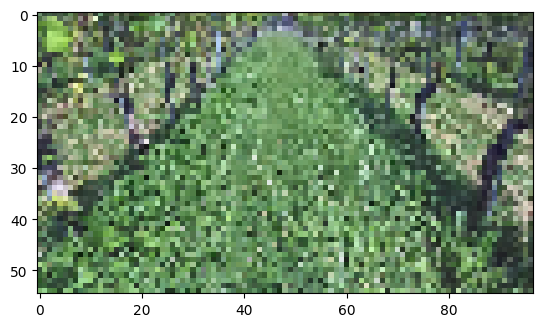

In [4]:
im_p = "/home/melon/Pictures/Screenshot from 2023-02-06 15-07-57.png"
im_p = "/home/melon/Pictures/Screenshot from 2023-01-18 10-36-14.png"
image = Image.open(im_p)
if image.mode != 'RGB':
    image = image.convert('RGB')


image_array = np.array(image)
print(image_array.shape)

height = int(param.resize * image_array.shape[0])
width = int(param.resize * image_array.shape[1])
if param.resize is not None:
    image_array = cv2.resize(image_array, dsize=(width, height))
print(image_array.shape)
plt.imshow(image_array)
image_array = cp.asarray(image_array)



In [39]:
features = feature_extractor["model"](image_array)

(5335, 10)
(55, 97, 3)


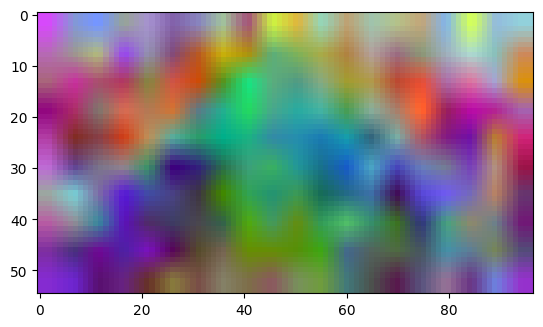

In [40]:
data = np.reshape(features.cpu().detach().numpy(), (features.shape[0], -1)).T
print(data.shape)
n_components = 3
pca = PCA(n_components=n_components).fit(data)
pca_descriptors = pca.transform(data)
img_pca = pca_descriptors.reshape(features.shape[1], features.shape[2], n_components)
print(img_pca.shape)
comp = img_pca  # [:, :, -3:]
comp_min = comp.min(axis=(0, 1))
comp_max = comp.max(axis=(0, 1))
comp_img = (comp - comp_min) / (comp_max - comp_min)
comp_img = (comp_img * 255).astype(np.uint8)
plt.imshow(comp_img,interpolation='nearest')